## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2024-10-30 15:43:23.761795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-30 15:43:23.780376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-30 15:43:23.781687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Reading Stock Market Data
Data comes from Microsoft or TATA Consulting firm. Data includes
- Open value
- Close value
- Highest daily value
- Lowest daily value

In [2]:
data_folder = './../data/stocks/'
stock = 'Microsoft'

if stock == 'Microsoft':
  dataset_file = data_folder + 'microsoft_stocks.csv'
  close_column ='Adj Close'                   # Close column name
  volume_column = 'Volume'                    # Volumen column name
else:
  dataset_file = data_folder + 'NSE_TATAGLOBAL11.csv'
  close_column ='Close'                       # Close column name
  volume_column = 'Total Trade Quantity'      # Volumen column name

# Read dataset and sort date ascending
df=pd.read_csv(dataset_file, na_values=['null'], index_col='Date', parse_dates=True)
df = df.sort_index(ascending=True, axis=0)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-12,47.540001,46.360001,47.419998,46.599998,23651900.0,40.786396
2015-01-13,47.910000,46.060001,46.970001,46.360001,35270600.0,40.576340
2015-01-14,46.240002,45.619999,45.959999,45.959999,29719600.0,40.226257
2015-01-15,46.380001,45.410000,46.220001,45.480000,32750800.0,39.806129
2015-01-16,46.279999,45.169998,45.310001,46.240002,35695300.0,40.471313


## Verify null or empty values

In [3]:
# Verify null or empty values
print("Null values?: ", df.isnull().values.any())

Null values?:  False


## Visualize stocks historical closing values

<Axes: xlabel='Date'>

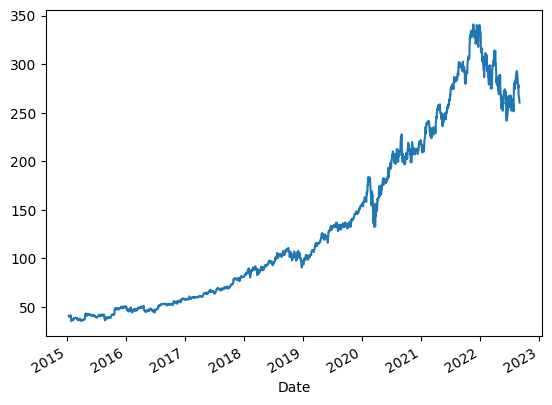

In [4]:
# Ploting closing: Adj Close or Close column
df[close_column].plot()

## Setting the Target Variable (expected output) and Features (input values)

In [5]:
# Target variable is closing value
close_target = pd.DataFrame(df[close_column])

# Features includes all other data
features_columns = ['Open', 'High', 'Low', volume_column]

## Scaling features (norm)

In [6]:
# Scaling form 1 to 0
scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(df[features_columns])
feature = pd.DataFrame(columns=features_columns, data=features, index=df.index)
feature.head()

,Open,High,Low,Volume
Date,,,,
2015-01-12,0.023268,0.022011,0.021952,0.100324
2015-01-13,0.021789,0.023209,0.020960,0.172161
2015-01-14,0.018470,0.017803,0.019505,0.137840
2015-01-15,0.019324,0.018257,0.018811,0.156581
2015-01-16,0.016334,0.017933,0.018018,0.174787


## Creating a Training and Test sets

In [7]:
# Splitting to datasets in 10 buckets
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(features):
        X_train, X_test = features[:len(train_index)], features[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = close_target[:len(train_index)].values.ravel(), close_target[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [8]:
X_train.shape

(1750, 4)

## Data shaping for LSTM

In [9]:
X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

## Building LSTM Model

In [10]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
#model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#model.add(LSTM(units=50))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


2024-10-30 15:43:23.899425: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 15:43:23.900551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-30 15:43:23.901967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-30 15:43:23.903165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Training the model

In [11]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=2, shuffle=False)

Epoch 1/100
110/110 - 0s - loss: 20536.1230 - 456ms/epoch - 4ms/step
Epoch 2/100


2024-10-30 15:43:24.389185: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


110/110 - 0s - loss: 20286.5918 - 111ms/epoch - 1ms/step
Epoch 3/100
110/110 - 0s - loss: 19885.8809 - 111ms/epoch - 1ms/step
Epoch 4/100
110/110 - 0s - loss: 19264.9668 - 114ms/epoch - 1ms/step
Epoch 5/100
110/110 - 0s - loss: 18404.3730 - 112ms/epoch - 1ms/step
Epoch 6/100
110/110 - 0s - loss: 17322.4883 - 111ms/epoch - 1ms/step
Epoch 7/100
110/110 - 0s - loss: 16063.7031 - 113ms/epoch - 1ms/step
Epoch 8/100
110/110 - 0s - loss: 14683.5146 - 111ms/epoch - 1ms/step
Epoch 9/100
110/110 - 0s - loss: 13237.9268 - 111ms/epoch - 1ms/step
Epoch 10/100
110/110 - 0s - loss: 11777.8750 - 110ms/epoch - 1ms/step
Epoch 11/100
110/110 - 0s - loss: 10346.9131 - 110ms/epoch - 1ms/step
Epoch 12/100
110/110 - 0s - loss: 8980.5020 - 113ms/epoch - 1ms/step
Epoch 13/100
110/110 - 0s - loss: 7706.0278 - 112ms/epoch - 1ms/step
Epoch 14/100
110/110 - 0s - loss: 6543.1177 - 112ms/epoch - 1ms/step
Epoch 15/100
110/110 - 0s - loss: 5504.1167 - 112ms/epoch - 1ms/step
Epoch 16/100
110/110 - 0s - loss: 4594.7290 

## Inference (prediction)

In [12]:
# Model prediction
y_pred= model.predict(X_test)

## Printing ground truth vs predicted value (Close value)
We print some days in the past and predicted value together with expected value

/tmp/ipykernel_112436/493990450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = y_pred


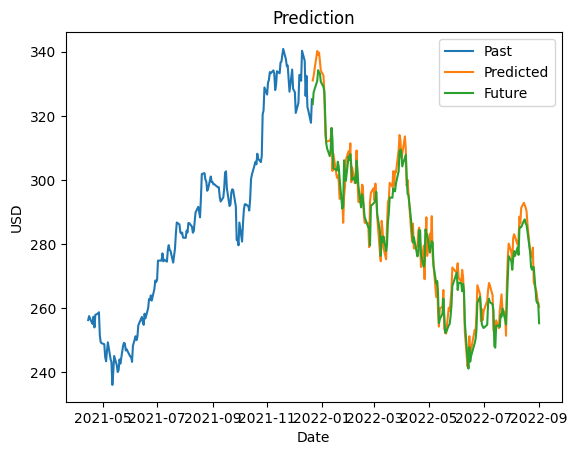

In [13]:
# Print some past(past) closing values to present (today). Then print target/predicted values
past = int(len(train_index)-len(train_index)/10)
today = len(train_index)
train = close_target[past:today]
test = close_target[today:]
test['Prediction'] = y_pred
plt.plot(train[close_column], label='Past')
plt.plot(test[[close_column, 'Prediction']], label=['Predicted', 'Future'])
plt.title("Prediction")
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.show()

